# Flowers
The mission here is to classify images of flowers using a convolutional neural network.
The steps will be:
- Download and load images of flowers
- Build a model with convolutional layers
- Fit the model to the images
- Predict and visualise

In [25]:
%load_ext nb_black
import os
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<IPython.core.display.Javascript object>

In [26]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
zip_file = tf.keras.utils.get_file(origin=_URL, fname="flower_photos.tgz", extract=True)
base_dir = os.path.join(os.path.dirname(zip_file), "flower_photos")
classes = ["roses", "daisy", "dandelion", "sunflowers", "tulips"]

<IPython.core.display.Javascript object>

We need to split the flower photos into training and validation sets.
Pick a fraction and move them.

In [58]:
TRAIN_FRACTION = 0.8
total_train = 0
total_val = 0
for flower_type in classes:
    flower_dir = os.path.join(base_dir, flower_type)
    flower_pics = glob.glob(f"{flower_dir}/*.jpg")
    train, val = (
        flower_pics[: round(len(flower_pics) * TRAIN_FRACTION)],
        flower_pics[round(len(flower_pics) * TRAIN_FRACTION) :],
    )
    total_train += len(train)
    total_val += len(val)

    flower_train_dir = os.path.join(base_dir, "train", flower_type)
    flower_val_dir = os.path.join(base_dir, "val", flower_type)
    if not os.path.exists(flower_train_dir):
        os.makedirs(flower_train_dir)
    if not os.path.exists(flower_val_dir):
        os.makedirs(flower_val_dir)

    for pic in train:
        if not os.path.exists(os.path.join(flower_train_dir, pic)):
            shutil.move(pic, flower_train_dir)
    for pic in val:
        if not os.path.exists(os.path.join(flower_val_dir, pic)):
            shutil.move(pic, flower_val_dir)
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

<IPython.core.display.Javascript object>

In [75]:
BATCH_SIZE = 32
IMG_SHAPE = 150

train_image_generator = ImageDataGenerator(
    rescale=1.0 / 255.0,
    horizontal_flip=True,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.5,
    fill_mode="nearest",
)
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    classes=classes,
    class_mode="binary",
)

val_image_generator = ImageDataGenerator(rescale=1.0 / 255.0)
val_data_gen = val_image_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=val_dir,
    shuffle=False,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    classes=classes,
    class_mode="binary",
)
print(val_data_gen)

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


<IPython.core.display.Javascript object>

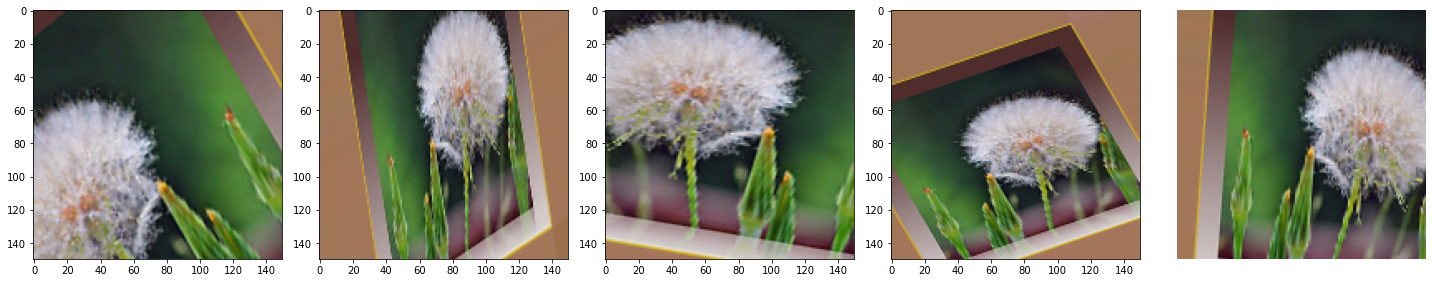

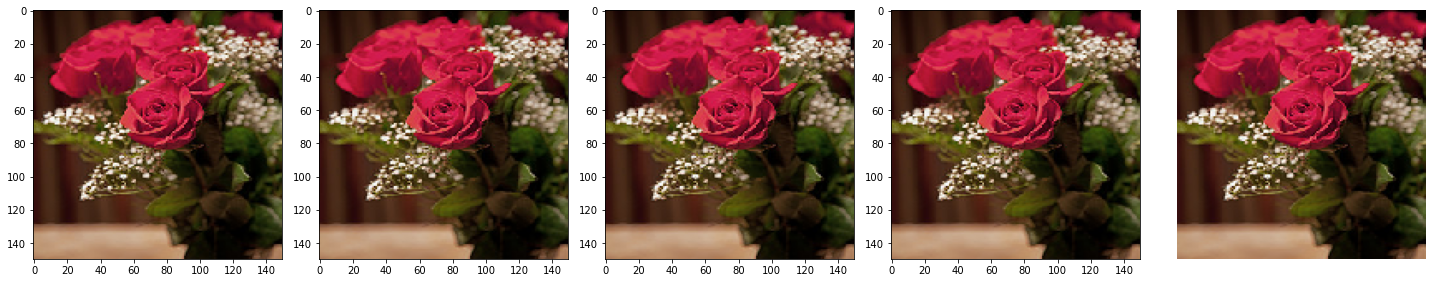

<IPython.core.display.Javascript object>

In [76]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


plot_images([train_data_gen[0][0][0] for _ in range(5)])
plot_images([val_data_gen[0][0][0] for _ in range(5)])

In [81]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3),
                           padding="same",
                           activation=tf.keras.activations.relu,
                           input_shape=(IMG_SHAPE, IMG_SHAPE, 3),),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    
    tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(len(classes))
])
print(classes)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()


['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 18, 18, 64)        0         
_______________________________________________________________

<IPython.core.display.Javascript object>

In [82]:
EPOCHS = 10
with tf.device("/GPU:0"):
    history = model.fit(
        train_data_gen,
        steps_per_epoch=round(total_train / BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=val_data_gen,
        validation_steps=round(total_val / BATCH_SIZE),
    )

Epoch 1/10
92/92 [==============================] - 26s 277ms/step - loss: 1.5654 - accuracy: 0.3372 - val_loss: 1.1801 - val_accuracy: 0.5619
Epoch 2/10
92/92 [==============================] - 24s 264ms/step - loss: 1.1116 - accuracy: 0.5664 - val_loss: 0.9975 - val_accuracy: 0.6218
Epoch 3/10
92/92 [==============================] - 24s 260ms/step - loss: 0.9995 - accuracy: 0.5944 - val_loss: 0.8789 - val_accuracy: 0.6694
Epoch 4/10
92/92 [==============================] - 23s 255ms/step - loss: 0.9034 - accuracy: 0.6484 - val_loss: 0.8639 - val_accuracy: 0.6762
Epoch 5/10
92/92 [==============================] - 25s 269ms/step - loss: 0.8838 - accuracy: 0.6343 - val_loss: 0.8054 - val_accuracy: 0.6980
Epoch 6/10
92/92 [==============================] - 24s 258ms/step - loss: 0.8306 - accuracy: 0.6654 - val_loss: 0.7644 - val_accuracy: 0.7279
Epoch 7/10
92/92 [==============================] - 26s 278ms/step - loss: 0.8151 - accuracy: 0.6689 - val_loss: 0.8892 - val_accuracy: 0.6830

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(EPOCHS), history.history["accuracy"], label="Training Accuracy")
ax.plot(range(EPOCHS), history.history["val_accuracy"], label="Validation Accuracy")
ax.legend()
fig.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(EPOCHS), history.history["loss"], label="Training Loss")
ax.plot(range(EPOCHS), history.history["val_loss"], label="Validation Loss")
ax.legend()
fig.show()